Rcsf = 11.02 ± 0.11
I_b = 0.07 ± 0.02
E = 0.87 ± 0.06
P_0 = 18.31 ± 0.2
File 1 / 1141


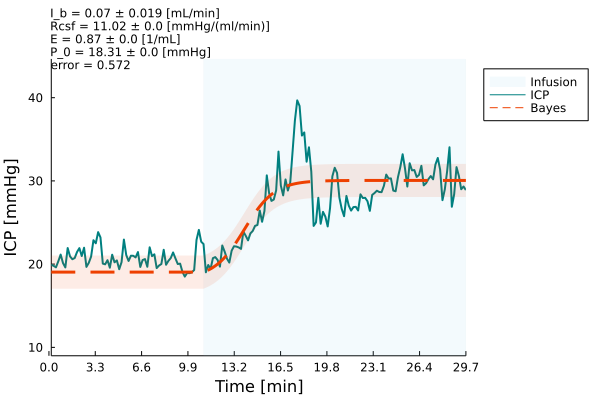

In [6]:
# Markov Chain Monte Carlo Maximum Likelihood Estimation
# Bayesian Model Comparison
# TODO: This is Metropolis algorithm. Rewrite for non-symmetric case (= Metropolis-Hastings) with bounds.
# Currently, bounds imposed by sigmoid regularization of the optimised variables

using HDF5, EzXML, Glob, Dates, Plots, Optim, Symbolics, JuMP, StatsBase, DataFrames, CSV, Random, Distributions
using CurveFit
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")

datapath = "/Users/jjc/CSF/Recordings/"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

global df = DataFrame(filename=files, Rcsf=NaN, E=NaN, Ib=NaN, P0=NaN, mode=NaN, error=NaN, R2=NaN, Pss=NaN, Rcsf_std=NaN, E_std=NaN, P0_std=NaN, Ib_std=NaN)

# for j = eachindex(files)
# for j  = 1:1000
# 990 good, 1141 good, 200 good
for j = 1

    j in [278, 442, 521, 621, 676, 708, 755, 989, 1010, 1041, 1042, 1043] ? (continue) : 0 # Some recordings do not have summaries data saved

    filename = files[j]
    # filename = "/Users/jjc/Documents/SSC/recs_june_2022/inf_20120717114717_INF2.hdf5"

    global Data = readCSF(filename)

    length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
    global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])

    D = Pm # Data

    global lb = [0.01, 0.01, -10.0, 0.1]
    global ub = [50.0, 1.0, Data["P_b"], 0.9]
    Ib_lower = lb[4]
    Ib_upper = ub[4]

    x0 = [Data["Rcsf"], Data["E"], Data["P_0"]]
    global θ₁ = x0
    y = solvemodel(θ₁...)
    y = y[Data["infusion_start_frame"]:end]

    σ = 1.0 # standard deviation for the model 
    χ₁ = sum((D .- y) .^ 2) / (2 * σ^2) #

    total_n = 50000 # Number of iterations
    burntime = 10000 # Burn time

    # total_n = 1000000 # Number of iterations
    # burntime = 100000 # Burn time
    a = [10.35, 0.14, 10.54] # Guess standard deviation
    # a = zeros(3) .+ 0.1 # Guess standard deviation for the parameters
    # a = zeros(3) .+ 1.0 # Guess standard deviation for the parameters = how wide around the current guess we want to deviate [0.01 good], higher = exploration, lower = exploitation
    # TODO: consider adding a different one to the I_b convergence to bounds

    global thetasave = zeros(3, total_n - burntime)
    global thetasave_t = zeros(3, total_n - burntime)
    global chisave = zeros(total_n - burntime)

    for i = 1:total_n

        θ₂ = θ₁ .+ a .* randn(3) # Normal distribution

        Rcsf = θ₁[1]
        E = θ₁[2]
        P_0 = θ₁[3]
        I_b = (Data["P_b"] - P_0) / Rcsf

        # while sum(Bool.([θ₁; I_b] .< lb)) > 0 || sum(Bool.([θ₁; I_b] .> ub)) > 0
        while I_b < lb[4] || I_b > ub[4]
            θ₂ = θ₁ .+ a .* randn(3) # Normal distribution
            Rcsf = θ₂[1]
            E = θ₂[2]
            P_0 = θ₂[3]
            I_b = (Data["P_b"] - P_0) / Rcsf
        end

        y = solvemodel(θ₂...)
        y = y[Data["infusion_start_frame"]:end]
        χ₂ = sum((D .- y) .^ 2) / (2 * σ^2)

        ratio = exp((-χ₂ + χ₁) / 2 * σ^2) # Likelihood ratio
        r = rand(1)[1] # Uniform distribution

        if r < ratio
            θ₁ = θ₂
            χ₁ = χ₂
        end

        ths = zeros(3)
        if i > burntime
            thetasave[:, i-burntime] = θ₁
            chisave[i-burntime] = χ₁
        end
    end

    Ib_all = zeros(total_n - burntime)
    global Ib_all .= (Data["P_b"] .- thetasave[3, :]) ./ thetasave[1, :]

    println("Rcsf = $(round(median(thetasave[1,:]),digits=2)) ± $(round(std(thetasave[1,:]),digits=2))")
    println("I_b = $(round(median(Ib_all),digits=2)) ± $(round(std(Ib_all),digits=2))")
    println("E = $(round(median(thetasave[2,:]),digits=2)) ± $(round(std(thetasave[2,:]),digits=2))")
    println("P_0 = $(round(median(thetasave[3,:]),digits=2)) ± $(round(std(thetasave[3,:]),digits=2))")

    opt_idx = findmin(chisave)[2]
    Rcsf = thetasave[1, opt_idx]
    E = thetasave[2, opt_idx]
    P_0 = thetasave[3, opt_idx]
    I_b = (Data["P_b"] - P_0) / Rcsf

    df.Rcsf[j] = (round(mean(thetasave[1, :]), digits=2))
    df.P0[j] = (round(mean(thetasave[3, :]), digits=2))
    df.Ib[j] = (round(mean(Ib_all), digits=2))
    df.E[j] = (round(mean(thetasave[2, :]), digits=2))
    df.filename[j] = filename[length(datapath)+2:end]
    df.error[j] = round(calc_model_plot(I_b, E, P_0)[2], digits=3)
    # global Pm = solvemodel(Rcsf, E, P_0)
    length(Data["ICP"]) > Data["infusion_end_frame"] ? (global Pm = Data["ICP"][Data["infusion_start_frame"]:Data["infusion_end_frame"]]) : (global Pm = Data["ICP"][Data["infusion_start_frame"]:end])
    global tslength = minimum([Data["infusion_end_frame"], length(Data["ICP"])])
    volRes, pressRes, fitted_curve, R2, MSE = press_vol_curve(Rcsf, P_0)
    df.R2[j] = round(R2, digits=3)
    df.Rcsf_std[j] = (round(std(thetasave[1, :]), digits=2))
    df.E_std[j] = (round(std(thetasave[2, :]), digits=2))
    df.P0_std[j] = (round(std(thetasave[3, :]), digits=2))
    df.Ib_std[j] = (round(std(Ib_all), digits=2))
    println("File $j / $(length(files))")

end

μ = mean(thetasave, dims=2)
σ = std(thetasave, dims=2)

opt_idx = findmin(chisave)[2]
Rcsf = thetasave[1, opt_idx]
E = thetasave[2, opt_idx]
P_0 = thetasave[3, opt_idx]
I_b = (Data["P_b"] - P_0) / Rcsf

rmserr = calc_model_plot(I_b, E, P_0)[2]
h0 = plotmodel(I_b, E, P_0, μ, σ, "dar", "")
title!("I_b = $(round(I_b,digits=2)) ± $(round(std(Ib_all),digits=3)) [mL/min]\n" * "Rcsf = $(round(value(Rcsf),digits=2)) ± $(round(std(thetasave_t[1,:]),digits=2)) [mmHg/(ml/min)]\n" * "E = $(round(value(E),digits=2)) ± $(round(std(thetasave_t[2,:]),digits=2)) [1/mL]\n" * "P_0 = $(round(value(P_0),digits=2)) ± $(round(std(thetasave_t[3,:]),digits=2)) [mmHg]\n" * "error = $rmserr", titlealign=:left, titlefontsize=8, xlabel="Time [min]", ylabel="ICP [mmHg]")

# icmp_curve = calc_model_plot((Data["P_b"]-Data["P_0"])/Data["Rcsf"], Data["E"], Data["P_0"])[1]
# plot!(icmp_curve, lw=2, alpha=0.7, label="∇ descent")

0